In [ ]:
import os
import argparse
from tqdm import tqdm
import urllib.request
import tarfile

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

# Enable optimized cudnn
torch.backends.cudnn.benchmark = True

def download_and_extract_caltech256(data_dir):
    """
    Download and extract Caltech256 dataset into data_dir/256_ObjectCategories.
    """
    caltech_root = os.path.join(data_dir, "256_ObjectCategories")
    if os.path.isdir(caltech_root):
        print("→ Caltech256 already present at", caltech_root)
        return caltech_root

    os.makedirs(data_dir, exist_ok=True)
    url = "http://www.vision.caltech.edu/Image_Datasets/Caltech256/256_ObjectCategories.tar"
    tar_path = os.path.join(data_dir, "256_ObjectCategories.tar")
    print(f"Downloading Caltech256 from {url} to {tar_path}...")
    urllib.request.urlretrieve(url, tar_path)
    print("Extracting Caltech256 archive...")
    with tarfile.open(tar_path) as tar:
        tar.extractall(path=data_dir)
    os.remove(tar_path)
    print("Caltech256 ready at", caltech_root)
    return caltech_root


def get_data_loaders(dataset, data_dir, batch_size, num_workers=4):
    """
    Returns train and validation loaders for CIFAR-10 or Caltech256.
    """
    if dataset.lower() == 'cifar10':
        num_classes = 10
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2470, 0.2435, 0.2616))
        ])
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2470, 0.2435, 0.2616))
        ])
        trainset = datasets.CIFAR10(root=data_dir, train=True,
                                    download=True, transform=transform_train)
        valset = datasets.CIFAR10(root=data_dir, train=False,
                                  download=True, transform=transform_test)

    elif dataset.lower() == 'caltech256':
        num_classes = 257
        transform_train = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])
        transform_test = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])
        caltech_root = os.path.join(data_dir, "256_ObjectCategories")
        full_dataset = datasets.ImageFolder(root=caltech_root, transform=transform_train)
        train_size = int(0.8 * len(full_dataset))
        val_size = len(full_dataset) - train_size
        trainset, valset = random_split(full_dataset, [train_size, val_size])
        # apply test transform to val split
        valset.dataset.transform = transform_test

    else:
        raise ValueError(f"Unsupported dataset: {dataset}")

    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=True)
    return train_loader, val_loader, num_classes


def build_model(num_classes, device, feature_extract=True):
    """
    Load pretrained ResNet50 and replace its classifier for num_classes.
    """
    model = models.resnet50(pretrained=True)
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model.to(device)


def train_one_epoch(model, loader, criterion, optimizer, device, scaler=None):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    use_amp = scaler is not None
    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        if use_amp:
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total


def validate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validation", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    return running_loss / total, correct / total


def evaluate_all(data_dir, batch_size, device, feature_extract):
    criterion = nn.CrossEntropyLoss()
    for ds in ['cifar10', 'caltech256']:
        print(f"\nEvaluating on {ds}:")
        _, val_loader, num_classes = get_data_loaders(ds, data_dir, batch_size)
        model = build_model(num_classes, device, feature_extract)
        ckpt = f"best_{ds}_resnet50.pth"
        if os.path.exists(ckpt):
            model.load_state_dict(torch.load(ckpt, map_location=device))
            loss, acc = validate(model, val_loader, criterion, device)
            print(f"{ds} --> Loss: {loss:.4f}, Acc: {acc:.4f}")
        else:
            print(f"Checkpoint not found for {ds}: {ckpt}")


def main():
    parser = argparse.ArgumentParser(description="ResNet50 Image Classification")
    parser.add_argument('--dataset', type=str, default='cifar10',
                        choices=['cifar10', 'caltech256'], help='Dataset to train')
    parser.add_argument('--data_dir', type=str, default='./data', help='Root data directory')
    parser.add_argument('--epochs', type=int, default=10, help='Training epochs')
    parser.add_argument('--batch_size', type=int, default=64, help='Batch size')
    parser.add_argument('--lr', type=float, default=0.001, help='Learning rate')
    parser.add_argument('--no_cuda', action='store_true', help='Disable CUDA')
    parser.add_argument('--feature_extract', action='store_true',
                        help='Freeze backbone, train classifier only')
    parser.add_argument('--mixed_precision', action='store_true',
                        help='Enable AMP mixed precision')
    parser.add_argument('--eval_all', action='store_true',
                        help='Evaluate trained models on both datasets')
    args, _ = parser.parse_known_args()

    device = torch.device('cuda' if torch.cuda.is_available() and not args.no_cuda else 'cpu')
    scaler = torch.cuda.amp.GradScaler() if args.mixed_precision and device.type == 'cuda' else None

    # Auto-download Caltech256 if needed
    if args.dataset.lower() == 'caltech256':
        download_and_extract_caltech256(args.data_dir)

    if args.eval_all:
        evaluate_all(args.data_dir, args.batch_size, device, args.feature_extract)
        return

    # Training workflow
    train_loader, val_loader, num_classes = get_data_loaders(
        args.dataset, args.data_dir, args.batch_size)
    model = build_model(num_classes, device, args.feature_extract)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD([p for p in model.parameters() if p.requires_grad],
                          lr=args.lr, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    best_acc = 0.0
    for epoch in range(1, args.epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader,
                                                criterion, optimizer, device, scaler)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        scheduler.step()
        print(f"Epoch {epoch}/{args.epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"best_{args.dataset}_resnet50.pth")
    print(f"Training complete. Best {args.dataset} Acc: {best_acc:.4f}")

    # Evaluate both
    evaluate_all(args.data_dir, args.batch_size, device, args.feature_extract)

if __name__ == '__main__':
    main()


In [ ]:
import os
import argparse
import urllib.request
import tarfile
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import datasets, models

# Enable optimized cudnn
torch.backends.cudnn.benchmark = True

def download_and_extract_caltech256(data_dir):
    """
    Download and extract Caltech256 into data_dir/256_ObjectCategories using CaltechDATA mirror.
    """
    caltech_root = os.path.join(data_dir, "256_ObjectCategories")
    if os.path.isdir(caltech_root):
        print(f"→ Caltech256 already present at {caltech_root}")
        return caltech_root

    os.makedirs(data_dir, exist_ok=True)
    url = "https://data.caltech.edu/records/nyy15-4j048/files/256_ObjectCategories.tar?download=1"
    tar_path = os.path.join(data_dir, "256_ObjectCategories.tar")
    print(f"Downloading Caltech256 to {tar_path}...")
    urllib.request.urlretrieve(url, tar_path)
    print("Extracting Caltech256 archive...")
    with tarfile.open(tar_path) as tar:
        tar.extractall(path=data_dir)
    os.remove(tar_path)
    print(f"Caltech256 ready at {caltech_root}")
    return caltech_root


def get_data_loaders(data_dir, batch_size, num_workers=4):
    """
    Returns train/validation loaders for Caltech256 (80/20 split).
    """
    root = download_and_extract_caltech256(data_dir)

    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    full = datasets.ImageFolder(root=root, transform=train_transform)
    total = len(full)
    split = int(0.8 * total)
    train_set, val_set = random_split(full, [split, total - split])
    val_set.dataset.transform = val_transform

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=True)
    return train_loader, val_loader, 257


def build_model(num_classes, device, feature_extract=True):
    model = models.resnet50(pretrained=True)
    if feature_extract:
        for p in model.parameters(): p.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)


def train_one_epoch(model, loader, criterion, optimizer, device, scaler=None):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in tqdm(loader, desc="Train", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        if scaler:
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
    return running_loss/total, correct/total


def validate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Val", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    return running_loss/total, correct/total


def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_dir', type=str, default='./data')
    parser.add_argument('--epochs', type=int, default=10)
    parser.add_argument('--batch_size', type=int, default=64)
    parser.add_argument('--lr', type=float, default=0.001)
    parser.add_argument('--no_cuda', action='store_true')
    parser.add_argument('--feature_extract', action='store_true')
    parser.add_argument('--mixed_precision', action='store_true')
    # Ignore Jupyter launcher args
    args, _ = parser.parse_known_args()

    device = torch.device('cuda' if torch.cuda.is_available() and not args.no_cuda else 'cpu')
    scaler = torch.cuda.amp.GradScaler() if args.mixed_precision and device.type=='cuda' else None

    train_loader, val_loader, num_classes = get_data_loaders(
        args.data_dir, args.batch_size)
    model = build_model(num_classes, device, args.feature_extract)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()),
                          lr=args.lr, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    best_acc = 0.0
    for epoch in range(1, args.epochs+1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion,
                                          optimizer, device, scaler)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        scheduler.step()
        print(f"Epoch {epoch}/{args.epochs} | Train Acc: {tr_acc:.4f} | Val Acc: {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_caltech256_resnet50.pth')
    print(f"Done. Best Val Acc: {best_acc:.4f}")

if __name__ == '__main__':
    main()


Extracting Caltech256 archive...
Caltech256 ready at ./data/256_ObjectCategories


Epoch 1/10 | Train Acc: 0.3046 | Val Acc: 0.5941


Epoch 2/10 | Train Acc: 0.7132 | Val Acc: 0.7890


Epoch 3/10 | Train Acc: 0.8340 | Val Acc: 0.8311


Epoch 4/10 | Train Acc: 0.8864 | Val Acc: 0.8443


Epoch 5/10 | Train Acc: 0.9231 | Val Acc: 0.8558


Epoch 6/10 | Train Acc: 0.9476 | Val Acc: 0.8589


Epoch 7/10 | Train Acc: 0.9681 | Val Acc: 0.8608


Epoch 8/10 | Train Acc: 0.9814 | Val Acc: 0.8616


Epoch 9/10 | Train Acc: 0.9824 | Val Acc: 0.8618


Epoch 10/10 | Train Acc: 0.9842 | Val Acc: 0.8621
Done. Best Val Acc: 0.8621


Extracting Caltech256 archive...
Caltech256 ready at ./data/256_ObjectCategories


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNe

Epoch 1/10 | Train Acc: 0.3009 | Val Acc: 0.5983


Epoch 2/10 | Train Acc: 0.7130 | Val Acc: 0.7890


Epoch 3/10 | Train Acc: 0.8355 | Val Acc: 0.8336


Epoch 4/10 | Train Acc: 0.8852 | Val Acc: 0.8469


Epoch 5/10 | Train Acc: 0.9209 | Val Acc: 0.8612


Epoch 6/10 | Train Acc: 0.9478 | Val Acc: 0.8675


Epoch 7/10 | Train Acc: 0.9666 | Val Acc: 0.8708


Epoch 8/10 | Train Acc: 0.9816 | Val Acc: 0.8700


Epoch 9/10 | Train Acc: 0.9820 | Val Acc: 0.8724


Epoch 10/10 | Train Acc: 0.9842 | Val Acc: 0.8714
Done. Best Val Acc: 0.8724
Evaluating best model with confusion matrix...


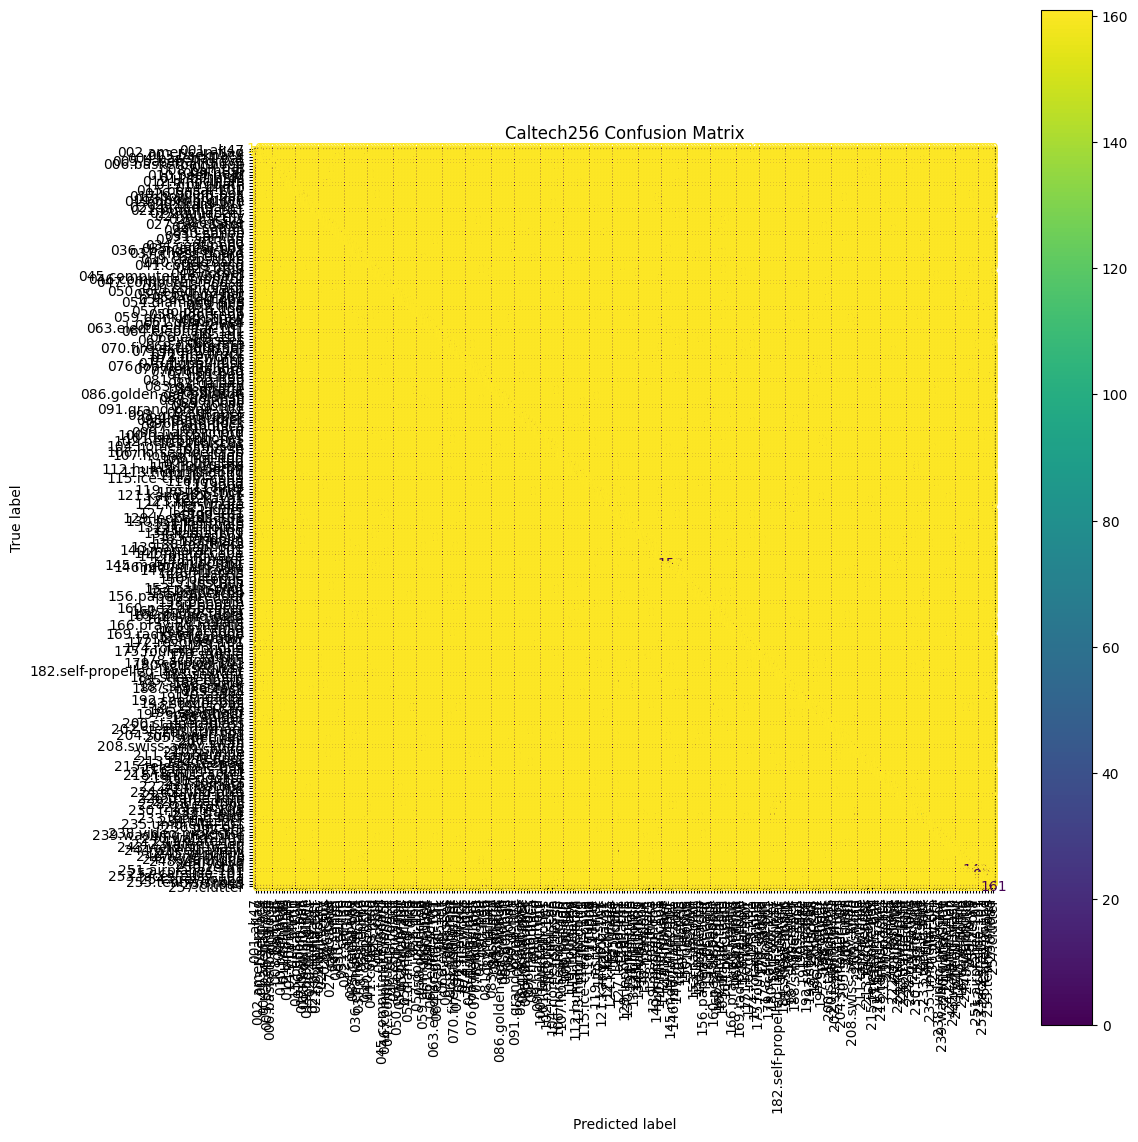

In [2]:
import os
import argparse
import urllib.request
import tarfile
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import datasets, models

torch.backends.cudnn.benchmark = True


def download_and_extract_caltech256(data_dir):
    caltech_root = os.path.join(data_dir, "256_ObjectCategories")
    if os.path.isdir(caltech_root):
        print(f"→ Caltech256 already present at {caltech_root}")
        return caltech_root

    os.makedirs(data_dir, exist_ok=True)
    url = "https://data.caltech.edu/records/nyy15-4j048/files/256_ObjectCategories.tar?download=1"
    tar_path = os.path.join(data_dir, "256_ObjectCategories.tar")
    print(f"Downloading Caltech256 to {tar_path}...")
    urllib.request.urlretrieve(url, tar_path)
    print("Extracting Caltech256 archive...")
    with tarfile.open(tar_path) as tar:
        tar.extractall(path=data_dir)
    os.remove(tar_path)
    print(f"Caltech256 ready at {caltech_root}")
    return caltech_root


def get_data_loaders(data_dir, batch_size, num_workers=4):
    root = download_and_extract_caltech256(data_dir)

    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    full = datasets.ImageFolder(root=root, transform=train_transform)
    total = len(full)
    split = int(0.8 * total)
    train_set, val_set = random_split(full, [split, total - split])
    val_set.dataset.transform = val_transform

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=True)
    return train_loader, val_loader, 257, full.classes


def build_model(num_classes, device, feature_extract=True):
    model = models.resnet50(pretrained=True)
    if feature_extract:
        for p in model.parameters():
            p.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)


def train_one_epoch(model, loader, criterion, optimizer, device, scaler=None):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in tqdm(loader, desc="Train", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        if scaler:
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total


def validate(model, loader, criterion, device, compute_cm=False, class_names=None):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Val", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
            if compute_cm:
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

    if compute_cm and class_names:
        cm = confusion_matrix(all_labels, all_preds)
        fig, ax = plt.subplots(figsize=(12, 12))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(ax=ax, xticks_rotation=90, cmap="viridis")
        plt.title("Caltech256 Confusion Matrix")
        plt.tight_layout()
        plt.show()

    return running_loss / total, correct / total


def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_dir', type=str, default='./data')
    parser.add_argument('--epochs', type=int, default=10)
    parser.add_argument('--batch_size', type=int, default=64)
    parser.add_argument('--lr', type=float, default=0.001)
    parser.add_argument('--no_cuda', action='store_true')
    parser.add_argument('--feature_extract', action='store_true')
    parser.add_argument('--mixed_precision', action='store_true')
    parser.add_argument('--compute_cm', action='store_true')
    args, _ = parser.parse_known_args()

    device = torch.device('cuda' if torch.cuda.is_available() and not args.no_cuda else 'cpu')
    scaler = torch.cuda.amp.GradScaler() if args.mixed_precision and device.type == 'cuda' else None

    train_loader, val_loader, num_classes, class_names = get_data_loaders(
        args.data_dir, args.batch_size)
    model = build_model(num_classes, device, args.feature_extract)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()),
                          lr=args.lr, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    best_acc = 0.0
    for epoch in range(1, args.epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion,
                                          optimizer, device, scaler)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        scheduler.step()
        print(f"Epoch {epoch}/{args.epochs} | Train Acc: {tr_acc:.4f} | Val Acc: {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_caltech256_resnet50.pth')
    print(f"Done. Best Val Acc: {best_acc:.4f}")

    print("Evaluating best model with confusion matrix...")
    model.load_state_dict(torch.load("best_caltech256_resnet50.pth", map_location=device))
    validate(model, val_loader, criterion, device, compute_cm=args.compute_cm, class_names=class_names)


if __name__ == '__main__':
    import sys
    sys.argv = ['script.py', '--compute_cm']
    main()


→ Caltech256 already present at ./data/256_ObjectCategories


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNe

[resnet50] Epoch 1/10  Train Acc: 0.3023  Val Acc: 0.5746


[resnet50] Epoch 2/10  Train Acc: 0.7064  Val Acc: 0.7751


[resnet50] Epoch 3/10  Train Acc: 0.8310  Val Acc: 0.8231


[resnet50] Epoch 4/10  Train Acc: 0.8844  Val Acc: 0.8453


[resnet50] Epoch 5/10  Train Acc: 0.9212  Val Acc: 0.8515


[resnet50] Epoch 6/10  Train Acc: 0.9481  Val Acc: 0.8610


[resnet50] Epoch 7/10  Train Acc: 0.9670  Val Acc: 0.8603


[resnet50] Epoch 8/10  Train Acc: 0.9819  Val Acc: 0.8644


[resnet50] Epoch 9/10  Train Acc: 0.9835  Val Acc: 0.8626


[resnet50] Epoch 10/10  Train Acc: 0.9846  Val Acc: 0.8639

Done. Best Val Acc (resnet50): 0.8644



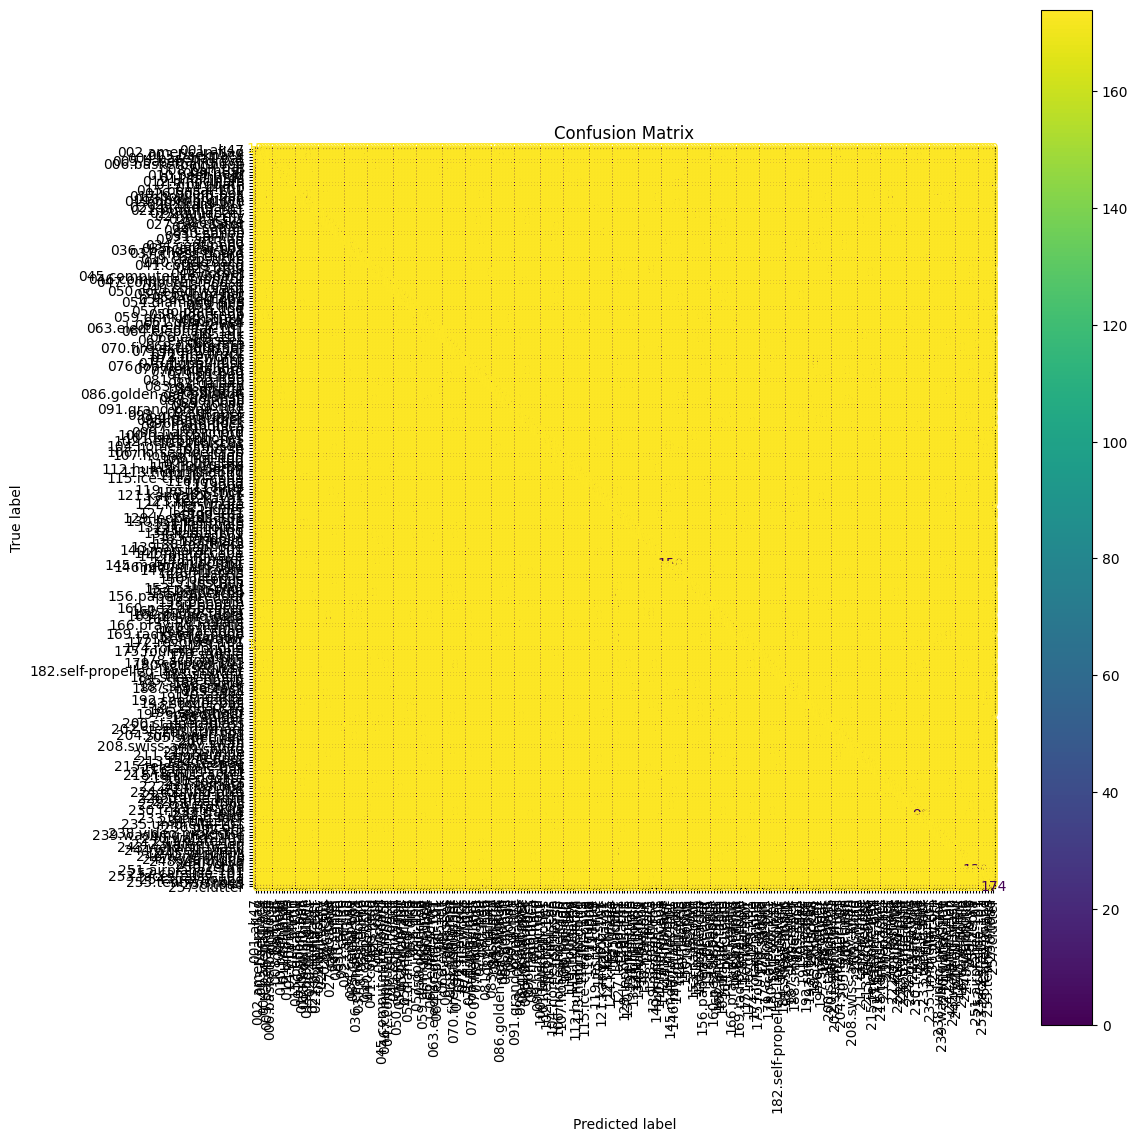

In [3]:
# caltech256_train_with_bit.py

import os
import sys
import argparse
import urllib.request
import tarfile
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import datasets, models

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1) If running in Colab/Jupyter, ignore extra args:
sys.argv = [sys.argv[0]] + [a for a in sys.argv[1:] if not a.startswith("-f")]

# 2) timm is needed for the Bit‐ResNet:
try:
    import timm
except ImportError:
    raise ImportError("Please install timm: pip install timm")

torch.backends.cudnn.benchmark = True


def download_and_extract_caltech256(data_dir):
    caltech_root = os.path.join(data_dir, "256_ObjectCategories")
    if os.path.isdir(caltech_root):
        print(f"→ Caltech256 already present at {caltech_root}")
        return caltech_root

    os.makedirs(data_dir, exist_ok=True)
    url = "https://data.caltech.edu/records/nyy15-4j048/files/256_ObjectCategories.tar?download=1"
    tar_path = os.path.join(data_dir, "256_ObjectCategories.tar")
    print(f"Downloading Caltech256 to {tar_path}...")
    urllib.request.urlretrieve(url, tar_path)
    print("Extracting Caltech256 archive...")
    with tarfile.open(tar_path) as tar:
        tar.extractall(path=data_dir)
    os.remove(tar_path)
    print(f"Caltech256 ready at {caltech_root}")
    return caltech_root


def get_data_loaders(data_dir, batch_size, num_workers=4):
    root = download_and_extract_caltech256(data_dir)
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    full = datasets.ImageFolder(root=root, transform=train_transform)
    split = int(0.8 * len(full))
    train_set, val_set = random_split(full, [split, len(full) - split])
    val_set.dataset.transform = val_transform

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=True)
    return train_loader, val_loader, full.classes


def build_model(name, num_classes, device, feature_extract):
    if name == "resnet50":
        model = models.resnet50(pretrained=True)
        if feature_extract:
            for p in model.parameters(): p.requires_grad = False
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "bit_r2_50":
        # BiT-ResNet-V2 @ HuggingFace / timm
        model = timm.create_model(
            'resnetv2_50x1_bit.goog_in21k_ft_in1k',
            pretrained=True,
            num_classes=num_classes
        )
        if feature_extract:
            for p in model.parameters(): p.requires_grad = False
    else:
        raise ValueError(f"Unknown model: {name}")
    return model.to(device)


def train_one_epoch(model, loader, criterion, optimizer, device, scaler=None):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for x, y in tqdm(loader, desc="Train", leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        if scaler:
            with torch.cuda.amp.autocast():
                out = model(x)
                loss = criterion(out, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
        running_loss += loss.item() * x.size(0)
        preds = out.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    return running_loss / total, correct / total


def validate(model, loader, criterion, device, compute_cm=False, class_names=None):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in tqdm(loader, desc="Val", leave=False):
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            running_loss += loss.item() * x.size(0)
            preds = out.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            if compute_cm:
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y.cpu().numpy())

    acc = correct / total
    if compute_cm and class_names is not None:
        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
        fig, ax = plt.subplots(figsize=(12, 12))
        disp.plot(ax=ax, xticks_rotation=90, cmap="viridis")
        plt.title("Confusion Matrix")
        plt.tight_layout()
        plt.show()
    return running_loss / total, acc


def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_dir',       type=str,   default='./data')
    parser.add_argument('--epochs',         type=int,   default=10)
    parser.add_argument('--batch_size',     type=int,   default=64)
    parser.add_argument('--lr',             type=float, default=0.001)
    parser.add_argument('--no_cuda',        action='store_true')
    parser.add_argument('--feature_extract',action='store_true')
    parser.add_argument('--mixed_precision',action='store_true')
    parser.add_argument('--compute_cm',     action='store_true')
    parser.add_argument('--model',          type=str,   default='resnet50',
                        choices=['resnet50','bit_r2_50'])
    args = parser.parse_args()

    device = torch.device('cuda' if torch.cuda.is_available() and not args.no_cuda else 'cpu')
    scaler = (torch.cuda.amp.GradScaler()
              if args.mixed_precision and device.type=='cuda' else None)

    train_loader, val_loader, class_names = get_data_loaders(args.data_dir, args.batch_size)
    model = build_model(args.model, len(class_names), device, args.feature_extract)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()),
                          lr=args.lr, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    best_acc = 0.0
    for epoch in range(1, args.epochs+1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader,
                                          criterion, optimizer, device, scaler)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        scheduler.step()
        print(f"[{args.model}] Epoch {epoch}/{args.epochs}  "
              f"Train Acc: {tr_acc:.4f}  Val Acc: {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"best_{args.model}.pth")

    print(f"\nDone. Best Val Acc ({args.model}): {best_acc:.4f}\n")
    # load best and compute confusion matrix
    model.load_state_dict(torch.load(f"best_{args.model}.pth", map_location=device))
    validate(model, val_loader, criterion, device,
             compute_cm=args.compute_cm, class_names=class_names)


if __name__ == '__main__':
    main()


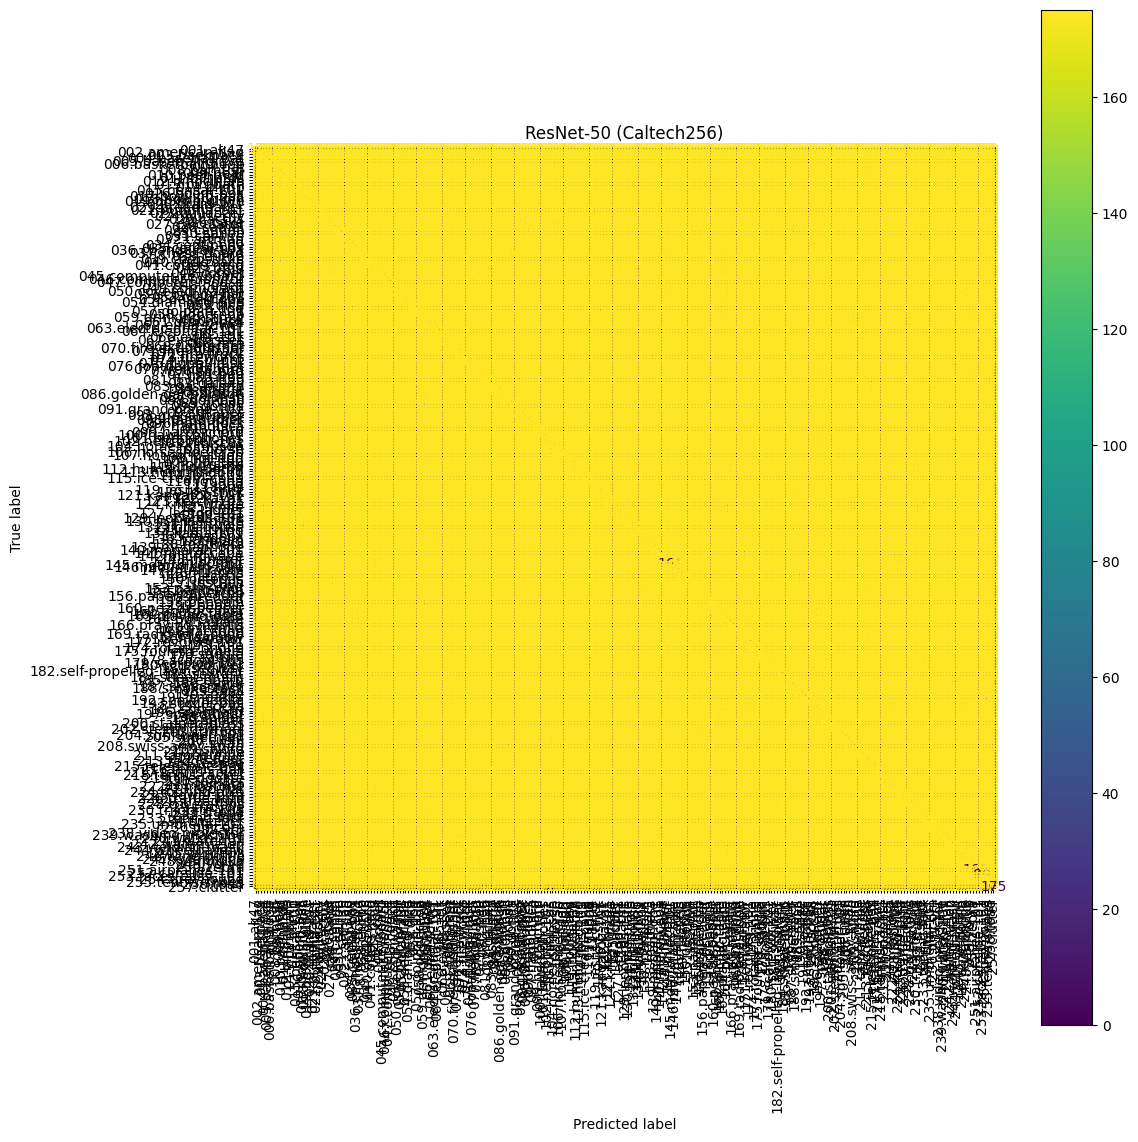

./best_bit_r2_50.pth not found – make sure you’ve saved your BiT checkpoint under that name


In [8]:
import os
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# If you used timm for BiT:
import timm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1️⃣ Prepare val_loader only on Caltech256
data_dir = './data'
root = os.path.join(data_dir, "256_ObjectCategories")
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])
full = datasets.ImageFolder(root=root, transform=val_transform)
split = int(0.8 * len(full))
_, val_set = random_split(full, [split, len(full)-split])
val_loader = DataLoader(val_set, batch_size=64, shuffle=False,
                        num_workers=4, pin_memory=True)
class_names = full.classes

# 2️⃣ Point at your root checkpoints
ckpt_dir = '.'  # checkpoint files are in the notebook root

# 3️⃣ Helper to load model + checkpoint
def load_model(name):
    if name == 'resnet50_caltech':
        ckpt_path = os.path.join(ckpt_dir, 'best_caltech256_resnet50.pth')
        if not os.path.isfile(ckpt_path):
            raise FileNotFoundError(f"{ckpt_path} not found")
        m = models.resnet50(pretrained=False)
        m.fc = torch.nn.Linear(m.fc.in_features, len(class_names))
        m.load_state_dict(torch.load(ckpt_path, map_location=device))

    elif name == 'bit_r2_50':
        ckpt_path = os.path.join(ckpt_dir, 'best_bit_r2_50.pth')
        if not os.path.isfile(ckpt_path):
            raise FileNotFoundError(f"{ckpt_path} not found – make sure you’ve saved your BiT checkpoint under that name")
        m = timm.create_model(
            'resnetv2_50x1_bit.goog_in21k_ft_in1k',
            pretrained=False,
            num_classes=len(class_names)
        )
        m.load_state_dict(torch.load(ckpt_path, map_location=device))

    else:
        raise ValueError(f"Unknown model key: {name}")

    return m.to(device)

# 4️⃣ Compute & plot confusion matrix
def compute_and_plot_cm(model, title):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(12,12))
    disp.plot(ax=ax, xticks_rotation=90, cmap='viridis')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# 5️⃣ Usage:

# — ResNet-50 on Caltech256
res_caltech = load_model('resnet50_caltech')
compute_and_plot_cm(res_caltech, "ResNet-50 (Caltech256)")

# — BiT-ResNet-V2 (if you have that checkpoint)
try:
    bit_model = load_model('bit_r2_50')
    compute_and_plot_cm(bit_model, "BiT-ResNet-V2 (Caltech256)")
except FileNotFoundError as e:
    print(e)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


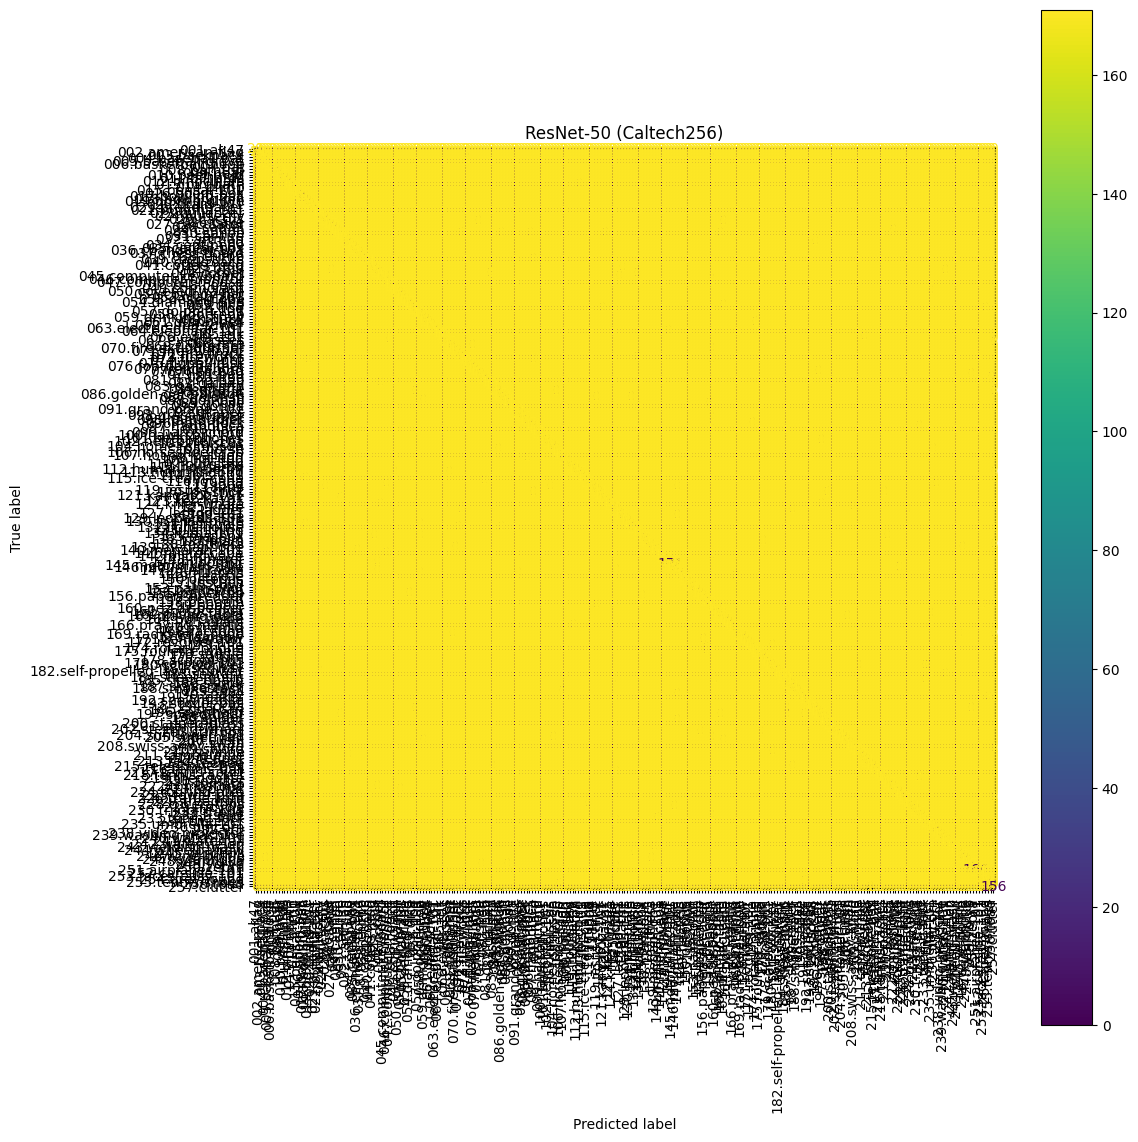

./best_bit_r2_50.pth not found – make sure you’ve saved your BiT checkpoint under that name


In [9]:
import os
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# If you used timm for BiT:
import timm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1️⃣ Prepare val_loader only on Caltech256
data_dir = './data'
root = os.path.join(data_dir, "256_ObjectCategories")
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])
full = datasets.ImageFolder(root=root, transform=val_transform)
split = int(0.8 * len(full))
_, val_set = random_split(full, [split, len(full)-split])
val_loader = DataLoader(val_set, batch_size=64, shuffle=False,
                        num_workers=4, pin_memory=True)
class_names = full.classes

# 2️⃣ Point at your root checkpoints
ckpt_dir = '.'  # checkpoint files are in the notebook root

# 3️⃣ Helper to load model + checkpoint
def load_model(name):
    if name == 'resnet50_caltech':
        ckpt_path = os.path.join(ckpt_dir, 'best_caltech256_resnet50.pth')
        if not os.path.isfile(ckpt_path):
            raise FileNotFoundError(f"{ckpt_path} not found")
        m = models.resnet50(pretrained=False)
        m.fc = torch.nn.Linear(m.fc.in_features, len(class_names))
        m.load_state_dict(torch.load(ckpt_path, map_location=device))

    elif name == 'bit_r2_50':
        ckpt_path = os.path.join(ckpt_dir, 'best_bit_r2_50.pth')
        if not os.path.isfile(ckpt_path):
            raise FileNotFoundError(f"{ckpt_path} not found – make sure you’ve saved your BiT checkpoint under that name")
        m = timm.create_model(
            'resnetv2_50x1_bit.goog_in21k_ft_in1k',
            pretrained=False,
            num_classes=len(class_names)
        )
        m.load_state_dict(torch.load(ckpt_path, map_location=device))

    else:
        raise ValueError(f"Unknown model key: {name}")

    return m.to(device)

# 4️⃣ Compute & plot confusion matrix
def compute_and_plot_cm(model, title):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(12,12))
    disp.plot(ax=ax, xticks_rotation=90, cmap='viridis')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# 5️⃣ Usage:

# — ResNet-50 on Caltech256
res_caltech = load_model('resnet50_caltech')
compute_and_plot_cm(res_caltech, "ResNet-50 (Caltech256)")

# — BiT-ResNet-V2 (if you have that checkpoint)
try:
    bit_model = load_model('bit_r2_50')
    compute_and_plot_cm(bit_model, "BiT-ResNet-V2 (Caltech256)")
except FileNotFoundError as e:
    print(e)
